<a href="https://colab.research.google.com/github/jordan-strasser/malaria-classifier/blob/main/Bioe279.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Benjamin Smith & Jordan Strasser

---
BioE 279 - Final Project


---
Malaria Detection in RBCs with Machine Learning 



First we import the necessary packages to implement the program. Some of these packages aren't used in the final code but were used in the process of visualizing the data. We mount google drive to the program in order to access the images that we are traing and validating the program with.

In [ ]:
import numpy as np
import os
import pathlib
import scipy.io
from PIL import Image
import glob
from scipy import ndimage
import matplotlib.pyplot as plt
from google.colab import files
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We need to establish what the minimum width and height of the images is in order to standardize the input vector. 

In [ ]:
# creates a list of all the photos which can be opened. Used our directory location
# please change accordingly
para_path = "/content/drive/MyDrive/Bioe279 - Final Project/cell_images/Parasitized/*.png"
para_imgs = list(glob.glob(para_path))

uninf_path = "/content/drive/MyDrive/Bioe279 - Final Project/cell_images/Uninfected/*.png"
uninf_imgs = list(glob.glob(uninf_path))

# establish a large starting point var so that we cann save the lowest one
wid_min = 1000
hgt_min = 1000

# loop through all the file names of the images, then open each one. Then if the current
# width or height dimension is lower than the svaed global minimum, save the new global
# minimum
for s in para_imgs:
  img = Image.open(s)
  wid = img.size[0]
  hgt = img.size[1]
  if wid < wid_min:
    wid_min = wid
  if hgt < hgt_min:
    hgt_min = hgt

print(wid_min)
print(hgt_min)

# Same as above but with the non-parasitized images
wid_min_u = 1000
hgt_min_u = 1000
for st in uninf_imgs:
  img = Image.open(st)
  wid = img.size[0]
  hgt = img.size[1]
  if wid < wid_min_u:
    wid_min_u = wid
  if hgt < hgt_min_u:
    hgt_min_u = hgt

print(wid_min_u)
print(hgt_min_u)

# via function minimum width is 49 pixels and minimum height is 49 pixels
# via function minimum width is 46 pixels and minimum height is 40 pixels

KeyboardInterrupt: ignored

Set up the training and validation data from the given data in our main directory. This was accessed from our google drive.

In [ ]:
# Save the path to the data as a string. This was location of our images 
# please change accordingly to correct location
main_directory = '/content/drive/MyDrive/Bioe279 - Final Project/cell_images'

# Set up the traing data set using 80% of the given images. Input the given
# minimum image size calculated from the function above. We wanted to use a square
# image in order to optimize the program so compress the images into 40x40 shape.

train = tf.keras.utils.image_dataset_from_directory(main_directory, 
                                                    labels='inferred',
                                                    validation_split=0.2,
                                                    subset="training",
                                                    image_size=(40, 40),
                                                    seed=123)

# Set up the validation training data set using 20% of the given images. Same
# parameters as above

validation = tf.keras.utils.image_dataset_from_directory(main_directory, 
                                                        labels='inferred',
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        image_size=(40, 40),
                                                        seed=123)

Found 27872 files belonging to 2 classes.
Using 22298 files for training.
Found 27872 files belonging to 2 classes.
Using 5574 files for validation.


We use autotune to help improve the prefetching process and to help optimize the runtime of our program. This dynamically tunes the values while the program runs helping performance of the model. This also helps prevent bottlenecking of data.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.Rescaling(1./255)

Now we are ready to build the model. We use various functions to help optimize the learning process and insure that all the data inserted into the model are the same shape as well as rbg values normalize to a float between 0 and 1. We used a sequential model that many different image classification programs used.

In [ ]:
# Establish that there are two classes we want to identify between
num_classes = 2

model = tf.keras.Sequential([
  # Rescale the rbg values and ensure that the images inserted are the correct dimensions
  tf.keras.layers.Rescaling(1./255, input_shape=(40,40,3)),
  
  # Apply a random flip either along the horizontal or vertical axis to prevent overfitting
  tf.keras.layers.RandomFlip('horizontal_and_vertical', seed=123),
  
  # Apply 2D convultion layer
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='selu'),
  
  # Apply max pooling layer
  tf.keras.layers.MaxPooling2D(),
  
  # Apply 2D convultion layer
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='selu'),
  
  # Apply max pooling layer
  tf.keras.layers.MaxPooling2D(),
  
  # Apply 2D convultion layer
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='selu'),
  
  # Apply max pooling layer
  tf.keras.layers.MaxPooling2D(),
  
  # Flattens the input
  tf.keras.layers.Flatten(),
  
  # Apply dense neural network layer over batch
  tf.keras.layers.Dense(128, activation='selu'),
  
  # Apply a random dopout of a data point to prevent overfitting
  tf.keras.layers.Dropout(0.1),

  # Apply dense neural network layer over classes
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  # Use the adam algorithm for optimization
  optimizer= 'adam' ,
  
  # Computes the cross-entropy loss from the given data
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  
  # Saves accuracy data from the model
  metrics=['accuracy'])

View the summary of our model and check to make sure there are no errors in the compilation.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 40, 40, 3)         0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 40, 40, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 40, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 20, 20, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                  

Now we fit the image classification model to our data. We found via continues experimentation that 30 epochs produced an optimal model. We use the train and validation data that we save before hand.

In [ ]:
epochs = 20
history = model.fit(
    train,
    validation_data=validation,
    epochs=epochs
)

Epoch 1/30
697/697 [==============================] - 53s 76ms/step - loss: 0.1039 - accuracy: 0.9631 - val_loss: 0.1284 - val_accuracy: 0.9530
Epoch 2/30
697/697 [==============================] - 53s 76ms/step - loss: 0.1033 - accuracy: 0.9650 - val_loss: 0.1228 - val_accuracy: 0.9546
Epoch 3/30
697/697 [==============================] - 53s 76ms/step - loss: 0.0998 - accuracy: 0.9656 - val_loss: 0.1183 - val_accuracy: 0.9577
Epoch 4/30
697/697 [==============================] - 53s 75ms/step - loss: 0.0999 - accuracy: 0.9651 - val_loss: 0.1219 - val_accuracy: 0.9553
Epoch 5/30
697/697 [==============================] - 53s 75ms/step - loss: 0.0977 - accuracy: 0.9659 - val_loss: 0.1188 - val_accuracy: 0.9584
Epoch 6/30
697/697 [==============================] - 52s 75ms/step - loss: 0.0934 - accuracy: 0.9660 - val_loss: 0.1159 - val_accuracy: 0.9607
Epoch 7/30
697/697 [==============================] - 53s 76ms/step - loss: 0.0947 - accuracy: 0.9669 - val_loss: 0.1361 - val_accuracy:

Save the model in order to access it in the future rather than rerunning the program. There were a couple of issues with saving due to the aspect of randomness in our random flip layer. This prevents the exact model from being saved but given the same seed will produce the same result.

In [ ]:
model.save('/content/drive/MyDrive/Bioe279 - Final Project')

KeyError: ignored

If we want to load a model that we saved, we run this code in order to reintroduce it into the program.

In [ ]:
path_load = '/content/drive/MyDrive/Bioe279 - Final Project/BioE279_final_project.pk1'
# load the model from disk
loaded_model = pickle.load(open(path_load, 'rb'))

Now we analyze the accuracy and loss of the model that we just fit. This code plots these metrics for each epoch. From these graphs we edited the model in order to optimize accuracy while minimizing loss.

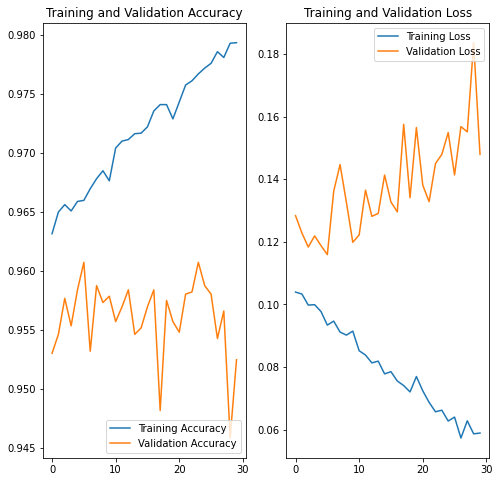

In [ ]:
a = history.history['accuracy']
va = history.history['val_accuracy']

l = history.history['loss']
vl = history.history['val_loss']

e = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(e, a, label='Training Accuracy')
plt.plot(e, va, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(e, l, label='Training Loss')
plt.plot(e, vl, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()